In [5]:
#Code from Fabio to import index data including applying comp matrix - JT mods added
import os
import sys
import math
import numpy as np
import numpy.linalg
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import fcsparser

In [61]:
#Functions defined here

def get_inx(meta : dict):
    i = 1
    key = f'INDEX SORTING LOCATIONS_{i}'
    sort_locs = [] #Sort locations from the metadata, numerical row then column starting at 0
    while key in meta:
        sort_locs.append(meta[key])
        i += 1
        key = f'INDEX SORTING LOCATIONS_{i}'
    sort_locs = ''.join(sort_locs).split(';')
    return sort_locs

Text(0.5, 0.98, 'PB plates')

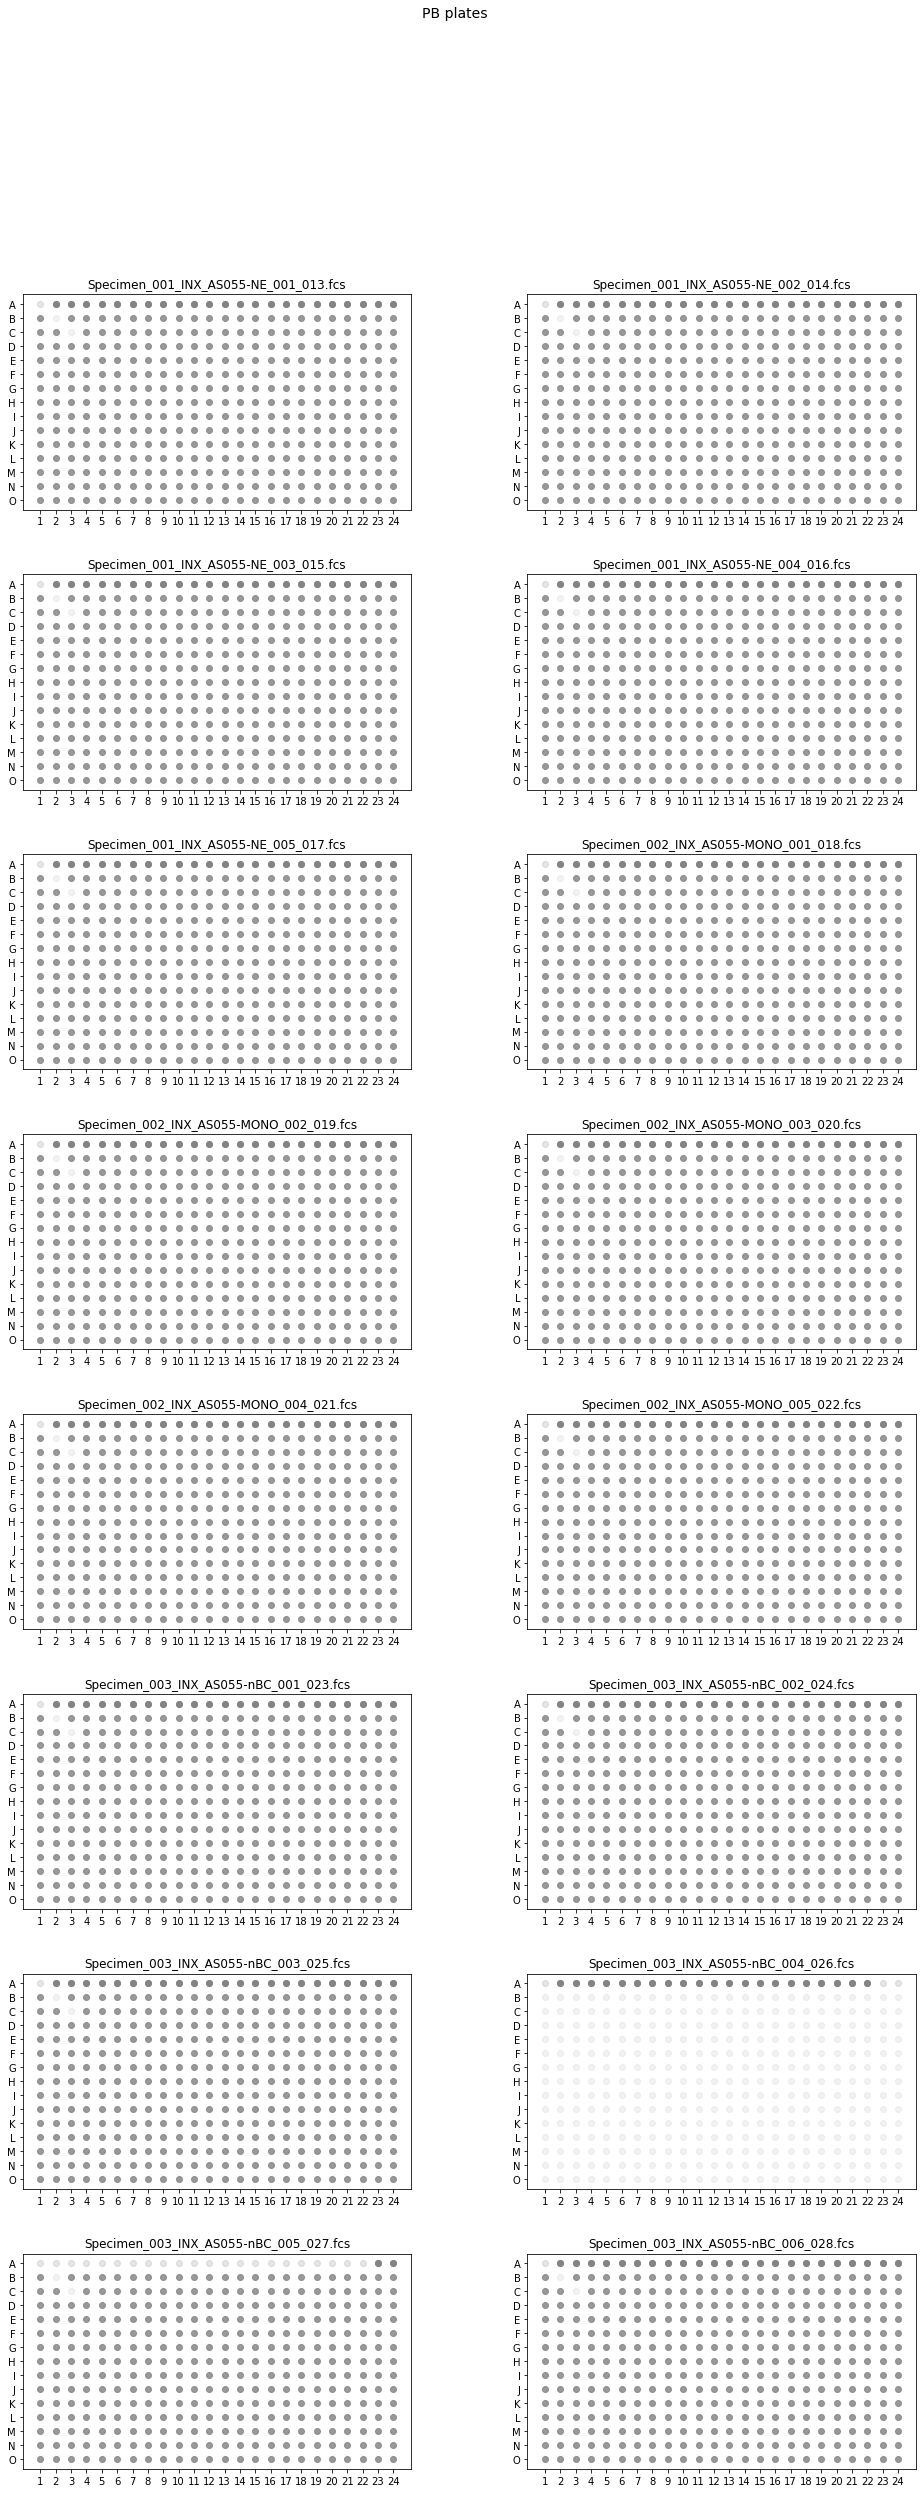

In [14]:
#Plate QC - check that cells are in the expected locations
#Note that one nBC plate has 2 index files associated - these are treated separaetly then the placeholder plate name replaced in the final df

directory = '../Data/RN_PB/Indexed/'

#Count the number of plates
count = 0
for filename in os.listdir(directory):
    count += 1
    
plotlen = int(math.ceil(count/2))    
    
#Set up the plots
fig, ax = plt.subplots(plotlen, 2, figsize = (16,(plotlen*5)))
ax = ax.ravel()
fig.subplots_adjust(hspace = 0.3, wspace=.3)

count = -1

xwell = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
ywell = [0,1,2,3,4,5,6,7,8,9,0,11,12,13,14,15]
allwells = []

for a in ywell: #this creates a list of all possible locations
    for b in xwell:
        allwells.append(str(a) + ','+ str(b))
        
#Read in files and plot the data for each

for filename in os.listdir(directory):
    fn = os.path.join(directory, filename)
    plateid = (fn.split('/'))[4]
    
    count += 1

    meta, data = fcsparser.parse(fn, reformat_meta=True)

    i = 1
    key = f'INDEX SORTING LOCATIONS_{i}'
    sort_locs = [] #Sort locations from the metadata, numerical row then column starting at 0
    while key in meta:
        sort_locs.append(meta[key])
        i += 1
        key = f'INDEX SORTING LOCATIONS_{i}'
    sort_locs = ''.join(sort_locs).split(';')

    for well in allwells:
        if well in sort_locs:  #if the well is in the list of wells with a sorted cell the colour will be darker
            alpha = 0.8
        else:
            alpha = 0.1        #plot empty wells in a lighter shade
            
        y, x = well.split(',')
        ax[count].scatter(x, y, alpha=alpha, color='gray')      
    ax[count].set_title(plateid)
    ax[count].invert_yaxis()  #flip the axis so the plate order looks natural
    ax[count].set_xticklabels(['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24'])
    ax[count].set_yticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'])

fig.suptitle('PB plates', fontsize=14)    
          
#plt.close()

In [59]:
#retrieve file names
fileplates = []

for filename in os.listdir(directory):
    fn = os.path.join(directory, filename)
    plateid = (fn.split('/'))[4]
    fileplates.append(plateid)

In [54]:
#Create list of plate names for renaming and for iteration
ampplates = [
    'not_seq_NE1',
    'AS-189',
    'not_seq_NE3',
    'not_seq_NE4',
    'AS-195',
    'not_seq_Mono1',
    'AS-187',
    'AS-193',
    'not_seq_Mono4',
    'not_seq_Mono5',
    'not_seq_nBC1',
    'not_seq_nBC2',
    'AS-194',
    'not_seq_nBC4a',
    'not_seq_nBC4',
    'AS-196'
]
ampplates2 = [
    'AS-189',
    'not_seq_NE3',
    'not_seq_NE4',
    'AS-195',
    'not_seq_Mono1',
    'AS-187',
    'AS-193',
    'not_seq_Mono4',
    'not_seq_Mono5',
    'not_seq_nBC1',
    'not_seq_nBC2',
    'AS-194',
    'not_seq_nBC4a',
    'not_seq_nBC4',
    'AS-196'
]

In [60]:
#Now read data into df and apply compensation, then output combined df with all rw or comp values
directory = '../Data/RN_PB/Indexed/'

data_dict = {}
data_dict_comp = {}

plate_key = dict(zip(fileplates, ampplates))

#Set up column rename dictionary - these were compiled by pulling a single index file df into excel to check column labels
col_name = {
    'YG582/15-A':'CD16-PE',
    'YG670/30-A':'CD14-Pe-Cy5',
    'YG780/60-A':'CD56-PE-Cy7',
    'V450/50-A':'CD66b-BV421',
    'V610/20-A':'Zombie',
    'B530/30-A':'CD45-FITC',
    'R660/20-A':'Cd27-APC',
    'R780/60-A':'R780/60-A',
    'B695/40-A':'IgD-BB700'
}


#Set up comp plots
fig, ax = plt.subplots(plotlen, 2, figsize = (8,(plotlen*3)))
ax = ax.ravel()
fig.subplots_adjust(hspace = 0.3, wspace=.3)

count = -1

#Read in files and metadata

for filename in os.listdir(directory):
    fn = os.path.join(directory, filename)
    plateid = (fn.split('/'))[4]
    count += 1

    meta, data = fcsparser.parse(fn, reformat_meta=True)

    i = 1
    key = f'INDEX SORTING LOCATIONS_{i}'
    sort_locs = []
    while key in meta:
        sort_locs.append(meta[key])
        i += 1
        key = f'INDEX SORTING LOCATIONS_{i}'
    sort_locs = ''.join(sort_locs).split(';')
    wells = []
    for loc in sort_locs:
        if loc == '':
            continue
        row_index, col = loc.split(',')
        col = str(int(col)+1)
        row = chr(65 + int(row_index)) #JT changed this to 65 from 64 - 65 is unicode for A, locations start at 0 (was 1 in test plate)
        well = row+col
        wells.append(well)   #Wells is a list of well locations with data derived from the index file
    
    # Get antibodies and rename with well names
    channel_idx = [int(x[2:-1]) for x in meta if x.startswith('$P') and x.endswith('S')]
    channeld = {meta['_channel_names_'][i-1]: meta[f'$P{i}S'] for i in channel_idx}

    data.index = pd.Index(wells, name='Sorted well') #Renames index with well name
    
    # Load compensation
    comp_fields = meta['SPILL'].split(',')
    n = int(comp_fields[0])
    channels = comp_fields[1: n+1]
    matrix = np.asarray(comp_fields[n+1:]).astype(np.float64).reshape((n, n)) 
    # TODO: perhaps transpose the matrix?
    # matrix = matrix.T
    spill_matrix = pd.DataFrame(
        matrix,
        index=channels,
        columns=channels,
    )  #spill_matrix is the comp matrix
    
    #Plots compensation matrix
    # Reorder the dyes by wavelength
    wls = [int(x.split('/')[0][-3:]) for x in channels]
    idx = np.argsort(wls)
    spill_by_wls = spill_matrix.iloc[idx].T.iloc[idx].T

    ax[count] = sns.heatmap(spill_by_wls, ax=ax[count])
    ax[count].set_title(plateid)

    
    #Apply comp and replace column names with antibodies
    data_comp = data.copy()
    compensation = spill_matrix
    # TODO: Perhaps the inverse matrix?
    #compensation.values = numpy.linalg.inv(compensation.values)
    for channel in channels:
        data_comp[channel] *= compensation.loc[channel].values @ data_comp[channels].values.T #@ here is doing the matrix multiplication
    
    #Store df and compdf for this iteration as a unique variable
    data_comp.rename(columns = channeld, inplace = True)
    data.rename(columns = channeld, inplace = True)
    
    plate = plate_key.get(filename) #pull the plate name for this file and use to label output dictionaries
    data['Well'] = data.index.get_level_values(0)
    data_comp['Well'] = data_comp.index.get_level_values(0)
    data['Plate'] = plate #add new column with plate name
    data_comp['Plate'] = plate  #add new column with plate name
    data_dict_comp[plate] = data_comp #output df into a dictionary
    data_dict[plate] = data  #output df into a dictionary      
  
fig.tight_layout()  
plt.close() #comment out to view comp plots

#Rename columns that have channel and not fluorophore
for p in data_dict.keys():
    for c in col_name.keys():
        if c not in data_dict[p]:
            continue
            
        else:
            data_dict[p].rename(columns = {c:col_name[c]}, inplace = True)

#Combine all data or data_comp df into a single large df for gating SHOULD THIS BE CONCAT INSTEAD?
PB_alldata = data_dict['not_seq_NE1']
PB_alldata_comp = data_dict_comp['not_seq_NE1']

for p in ampplates2:
    PB_alldata = PB_alldata.append(data_dict[p], ignore_index=True)
    PB_alldata_comp = PB_alldata_comp.append(data_dict[p], ignore_index=True)

#print((PB_alldata.shape[0])/15) #QC lines to check that there are 381 cells for each of 15 plates
#print(PB_alldata.shape[0]) 

#Need to rename ['Plate'] 'not_seq_nBC4a' to 'not_seq_nBC4'
PB_alldata['Plate'] = PB_alldata['Plate'].replace({'not_seq_nBC4a':'not_seq_nBC4'})
PB_alldata_comp['Plate'] = PB_alldata_comp['Plate'].replace({'not_seq_nBC4a':'not_seq_nBC4'})

#Add column to combine plate and well
PB_alldata['Plate_Well'] = PB_alldata['Plate'].astype(str) + '_' + PB_alldata['Well'].astype(str)
PB_alldata_comp['Plate_Well'] = PB_alldata_comp['Plate'].astype(str) + '_' + PB_alldata['Well'].astype(str)


In [ ]:
#Still not happy with the compensation, TO DO - fix it - see also CD34 notebook
#compensation.values = numpy.linalg.inv(compensation.values) 
#Returns an error, need to ask FZ for help
#AttributeError: can't set attribute

In [ ]:
#Let's just get on with plotting

sourcedata = PB_alldata.copy()  #Can swap to a different df here to look at compensated data

#Here's what's being plotted - update the plotlist
plot_list = [
    ['FSC-A', 'SSC-A'],
    ['FSC-A', 'FSC-W'],
    ['SSC-A', 'SSC-H'],
    ['Zombie', 'CD45-FITC'], 
    ['CD34-PE', 'CD38-APC-cy7'],
    ['IL1RAP-APC', 'CD38-APC-cy7'],
    ['CD45RA-FITC', 'CD123-PE-Cy7'],
    ['CD45RA-FITC', 'CD90-BV421']
]

    'YG582/15-A':'CD16-PE',
    'YG670/30-A':'CD14-Pe-Cy5',
    'YG780/60-A':'CD56-PE-Cy7',
    'V450/50-A':'CD66b-BV421',
    'V610/20-A':'Zombie',
    'B530/30-A':'CD45-FITC',
    'R660/20-A':'Cd27-APC',
    'R780/60-A':'R780/60-A',
    'B695/40-A':'IgD-BB700'
#Define colour palette here, and make a new column for it (c=  can only take a number or colour, not a categorical)
plates = sourcedata['Plate'].drop_duplicates().to_list()
cols = ['gray', 'green', 'green', 'red'] #can replace the colours used here
palette = dict(zip(plates, cols))

sourcedata['Colour'] = sourcedata['Plate'].replace(palette)

#Proposed gate locations
gate_loc = {
    'Lin-PE-Cy5': 2000,
    'CD34-PE': 280 ,
    'CD38-APC-cy7': 3000 ,
    'CD45RA-FITC': 1500 ,
    'CD123-PE-Cy7': 400,
    'Zombie': 8000,
    'IL1RAP-APC': 1200,
    'CD90-BV421': 500,
}

#Which fluorophores are on a log scale
logs = ['Lin-PE-Cy5', 'CD34-PE','CD38-APC-cy7', 'CD45RA-FITC','CD123-PE-Cy7','Zombie', 'IL1RAP-APC', 'CD90-BV421' ]

fix, axs = plt.subplots(4,2, figsize = (13,24))
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.3, wspace=.3)

for ax,y in zip(axs, plot_list):
    x_label = y[0]
    y_label = y[1]
    ax.scatter(sourcedata[x_label] + 11, sourcedata[y_label] + 11, alpha = 0.3, c = sourcedata['Colour'], s = 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
   #ax.legend()
    if x_label in logs:
        ax.set_xscale('log')
        ax.set_xlim(left = 10)
    if y_label in logs:
        ax.set_yscale('log')
        ax.set_ylim(bottom = 10)
    if x_label in gate_loc:
        ax.axvline(gate_loc[x_label], ls = '--', c = 'k')
    if y_label in gate_loc:
        ax.axhline(gate_loc[y_label], ls = '--', c = 'k')   
        
    ax.autoscale_view()  
    
fig.tight_layout()    